In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [238]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from utils import *

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_10/')

In [259]:
errors = compute_errors(data_path)#, sample=100, force_sample=True)

  0%|          | 0/5 [00:00<?, ?it/s]

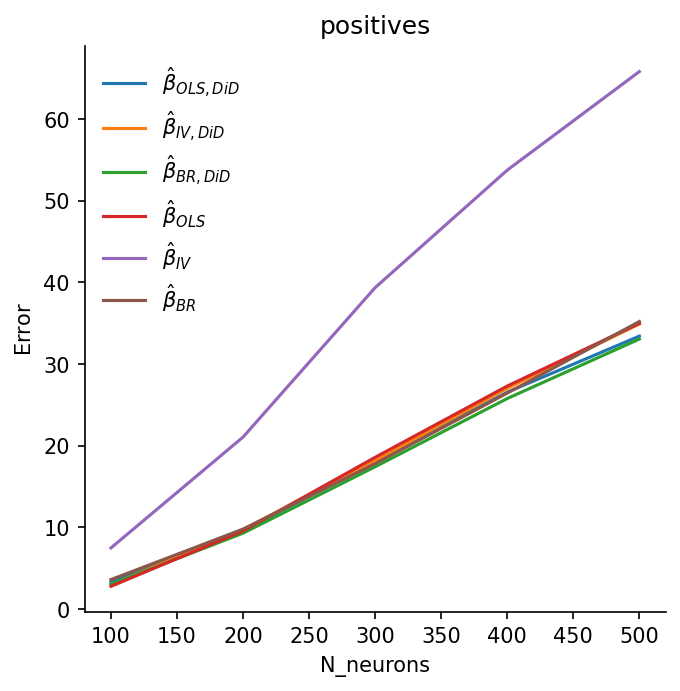

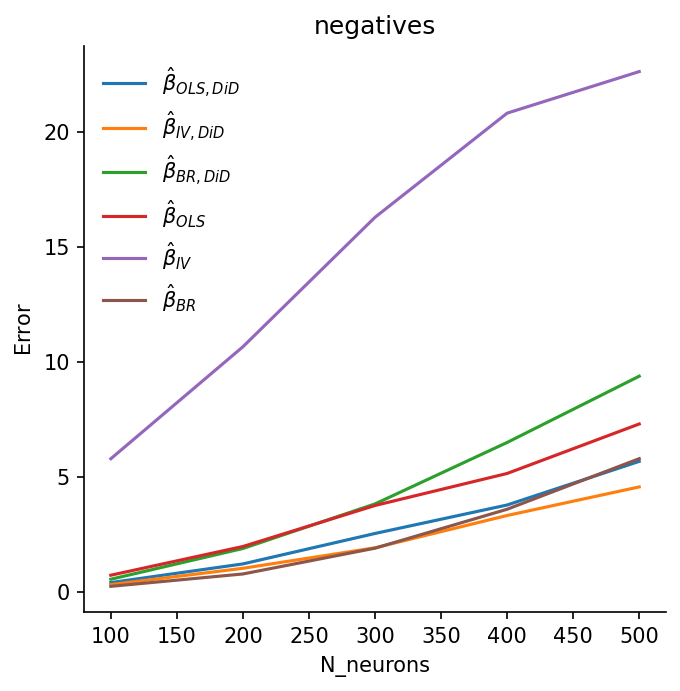

In [260]:
plot_errors(errors, 'n_neurons')

In [4]:
error_trials = compute_error_trials(data_path, n_samples=100)

  0%|          | 0/500 [00:00<?, ?it/s]

In [6]:
errors = compute_error_confidence(errors, error_trials)

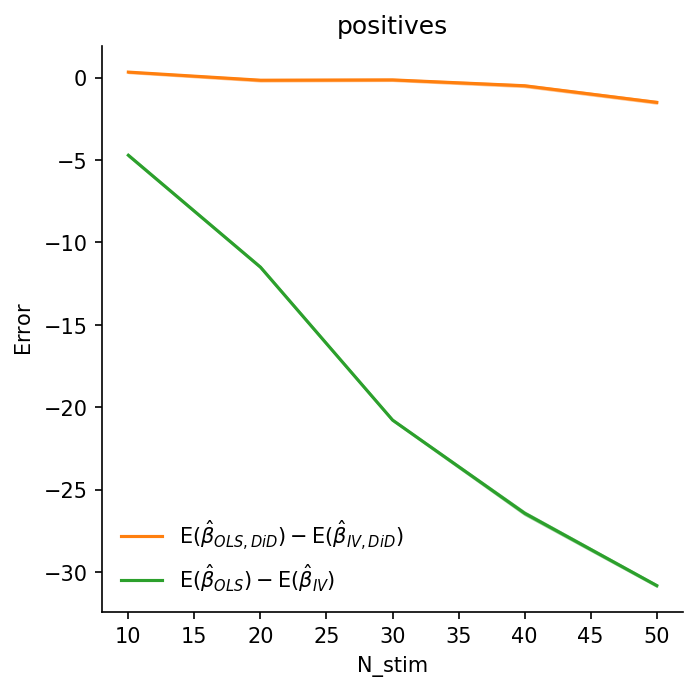

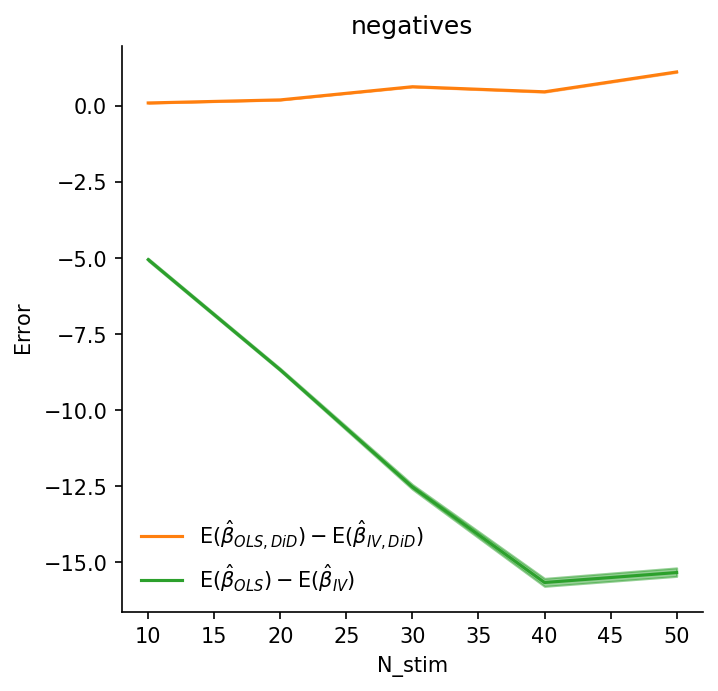

In [8]:
plot_error_difference(errors, 'n_stim')

# Convergence

In [9]:
error_convergence = compute_error_convergence(data_path)

  0%|          | 0/800 [00:00<?, ?it/s]

In [10]:
error_convergence_trials = compute_error_convergence_trials(data_path, n_samples=100)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [11]:
samples = compute_all_samples(data_path)

  0%|          | 0/5 [00:00<?, ?it/s]

In [261]:
index = int(errors['positives'].query('n_neurons==100').index.values)
index

3

In [262]:
errors['positives'].loc[index]

path                   /home/users/bjornmik/datasets/sweep_10/realist...
const                                                                5.0
n_neurons                                                          100.0
n_neurons_ex                                                        80.0
n_neurons_in                                                        20.0
dt                                                                 0.001
ref_scale                                                           10.0
abs_ref_scale                                                        3.0
spike_scale                                                          5.0
abs_ref_strength                                                  -100.0
rel_ref_strength                                                   -30.0
stim_scale                                                           2.0
stim_strength                                                        7.0
stim_period                                        

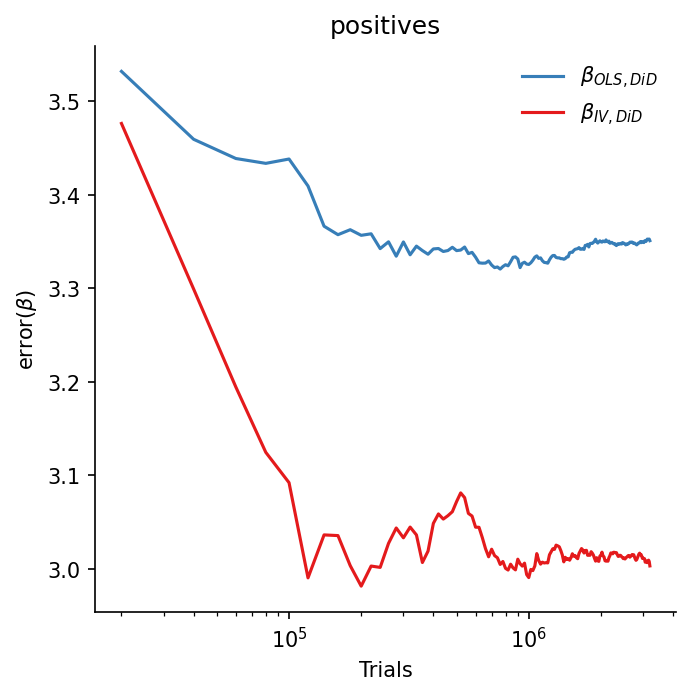

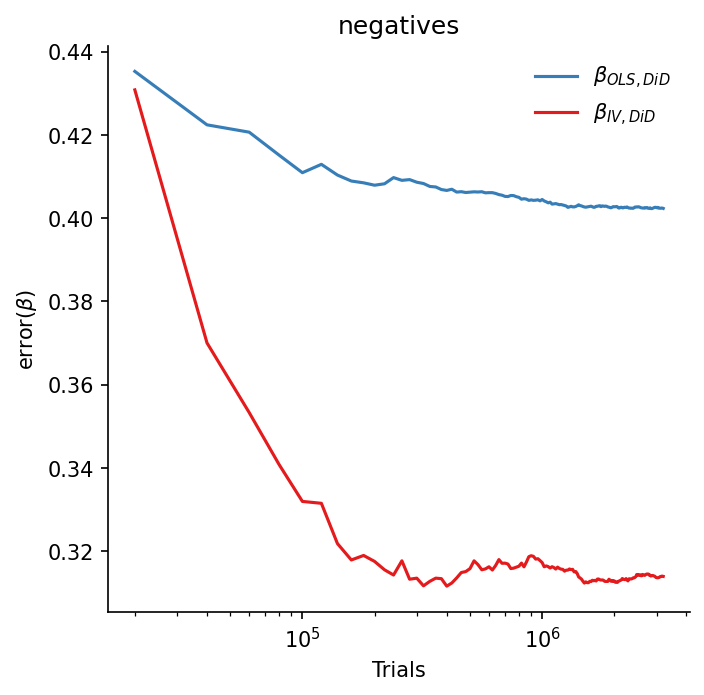

In [265]:
plot_error_convergence(error_convergence, index, ['error_beta_ols_did', 'error_beta_iv_did'])

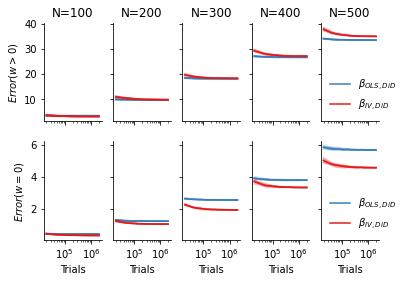

In [15]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey='row')
for i, (n_neurons, df) in enumerate(errors['positives'].groupby('n_neurons')):
    index = int(df.index.values)
    plot_error_convergence_trials( 
        error_convergence_trials, 
        index, 
        keys=['error_beta_ols_did','error_beta_iv_did'], 
        axs=axs.T[i], legend=i==4, xlabels=(False,True), ylabels=[i==0]*2)
    axs[0,i].set_title(f'N={n_neurons:.0f}')

# Regression

In [266]:
df = samples[index]

<AxesSubplot:>

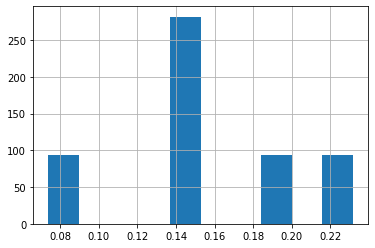

In [267]:
df.hit_rate.hist()

In [268]:
df['ww'] = df.hit_rate.round(3)

In [269]:
subsample = df.groupby('ww').sample(df.groupby('ww').count().source.min())

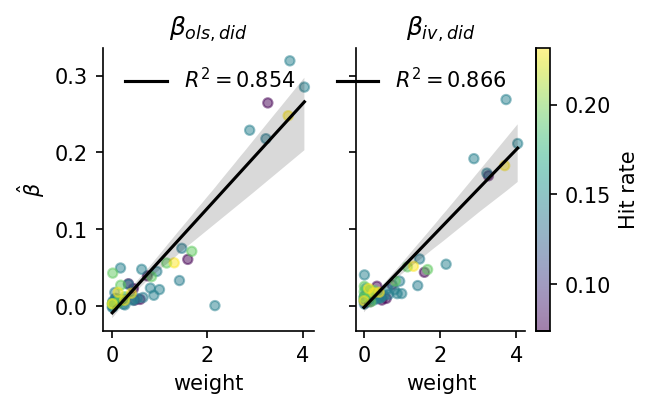

In [270]:
plot_regression(subsample.query('weight>0'), ['beta_ols_did','beta_iv_did'], scatter_kws=dict(s=20, alpha=.5), clabel='Hit rate')

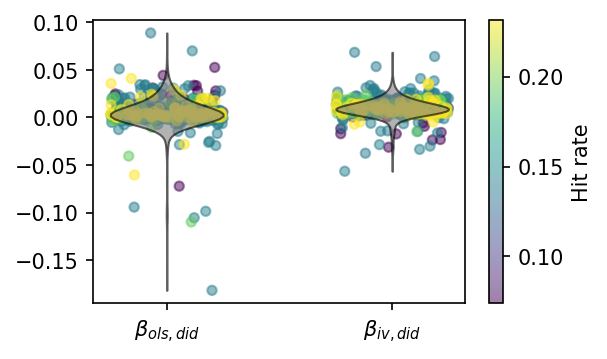

In [271]:
plot_false_positives(subsample.query('weight==0'), ['beta_ols_did', 'beta_iv_did'], scatter_kws=dict(s=20, alpha=.5), clabel='Hit rate')

# Classify

In [291]:
df = samples[index]

In [292]:
# df = rectify_keys(df, ['beta_ols_did', 'beta_iv_did'])

In [293]:
from sklearn import linear_model

In [294]:
df['is_connected'] = df.apply(lambda x: x.weight > 0, axis=1)

In [295]:
sum(df.weight == 0), sum(df.weight > 0), len(df)

(508, 56, 564)

test score:  0.8900709219858156


/home/users/bjornmik/.pyenv/versions/iv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(34.588912760416676, 0.5, 'beta_iv_did')

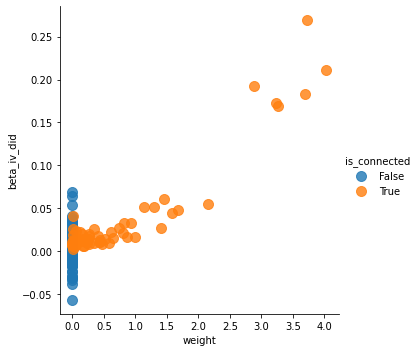

In [296]:
# class_weight = {0: len(df) / (2 * sum(df.weight == 0)), 1: len(df) / (2 * sum(df.weight > 0))}
log = linear_model.LogisticRegression(class_weight='balanced', C=1)

y = 'beta_iv_did'

log.fit(df[y].values.reshape(-1, 1), df['is_connected'].values)
test_score = log.score(df[y].values.reshape(-1, 1), df['is_connected'])
print("test score: ", test_score)

# Create scatterplot of dataframe
sns.lmplot('weight', # Horizontal axis
           y, # Vertical axis
           data=df, # Data source
           fit_reg=False, # Don't fix a regression line
           hue="is_connected", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size

plt.xlabel('weight')
plt.ylabel(y)

In [321]:
threshold = -log.intercept_ / log.coef_[0]
threshold

array([0.02419091])

In [325]:
df[y+'_pred'] = df[y].values > threshold

Text(37.924798177083346, 0.5, 'beta_iv_did')

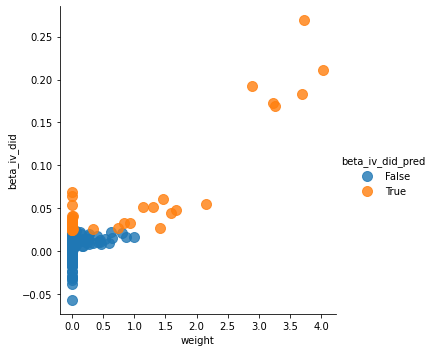

In [326]:
sns.lmplot('weight', # Horizontal axis
           y, # Vertical axis
           data=df, # Data source
           fit_reg=False, # Don't fix a regression line
           hue=y+'_pred', # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size

plt.xlabel('weight')
plt.ylabel(y)

In [299]:
import sklearn.metrics as sm 
# accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve

In [300]:
a = log.predict(df[y].values.reshape(-1,1))

In [301]:
b = df[y].values > threshold

In [302]:
(a == b).all()

True

In [303]:
y_true, y_pred = df['is_connected'],  log.predict(df[y].values.reshape(-1,1))

Accuracy Score 0.8900709219858156
Balanced accuracy Score 0.6450365579302587
Area Under Curve 0.6450365579302587
Recall score 0.3392857142857143
Confusion Matrix
[[0.9507874  0.0492126 ]
 [0.66071429 0.33928571]]


<AxesSubplot:>

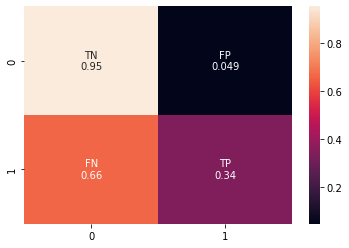

In [314]:
print(f'Accuracy Score', sm.accuracy_score(y_true, y_pred))
print(f'Balanced accuracy Score', sm.balanced_accuracy_score(y_true, y_pred))
print(f'Area Under Curve', sm.roc_auc_score(y_true, y_pred))
print(f'Recall score', sm.recall_score(y_true, y_pred))
confmat = sm.confusion_matrix(y_true, y_pred, normalize='true')
print(f'Confusion Matrix')
print(confmat)
tn, fp, fn, tp = confmat.ravel()
sns.heatmap(confmat, annot=np.array([[f'TN\n{tn:.2g}', f'FP\n{fp:.2g}'], [f'FN\n{fn:.2g}', f'TP\n{tp:.2g}']]), fmt='')

In [305]:
print(f'Accuracy Score weighted', sm.accuracy_score(y_true, y_pred, sample_weight=1+df[y]))
print(f'Balanced accuracy Score', sm.balanced_accuracy_score(y_true, y_pred, sample_weight=1+df[y]))
print(f'Confusion Matrix')
print(sm.confusion_matrix(y_true, y_pred, sample_weight=1+df[y]))
print(f'Area Under Curve', sm.roc_auc_score(y_true, y_pred, sample_weight=1+df[y]))
print(f'Recall score', sm.recall_score(y_true, y_pred, sample_weight=1+df[y]))

Accuracy Score weighted 0.8891270013567902
Balanced accuracy Score 0.6528130512091511
Confusion Matrix
[[487.03128286  25.83182024]
 [ 37.48417986  20.72052327]]
Area Under Curve 0.6528130512091512
Recall score 0.3559939687878845


In [318]:
sm.confusion_matrix(y_true, y_pred)

array([[483,  25],
       [ 37,  19]])

In [311]:
sm.confusion_matrix(y_true, y_pred, normalize='all') 

array([[0.85638298, 0.04432624],
       [0.06560284, 0.03368794]])